In [1]:
from functools import partial
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.data.data import MixtureNormalSampler
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field
from entot.plotting.plots import plot_1D_balanced
from entot.data.distributions_new import (
    GaussianMixture,
    SklearnDistribution, 
    SphereDistribution,
    RectangleUniform,
    BallUniform,
    Dataset
)
from typing import Optional
from entot.nets.nets import MLP_bridge
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, acceleration
import numpy as np
import matplotlib.gridspec as gridspec

source = SklearnDistribution(
    name="swiss",
    dim_data=3,
    noise=0.1,
    scale=.2
)
target = SklearnDistribution(
    name="swiss",
    noise=0.5,
    scale=.2
)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: I

In [2]:
neural_net = MLP_vector_field(2, latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(2, 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=5e-3, linear_ot_solver=linear_ot_solver)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, scale_cost="mean", iterations=10000, input_dim=3, output_dim=2, ot_solver=solver, k_noise_per_x=1)

In [3]:
otfm(iter(source), iter(target))

100%|██████████| 10000/10000 [33:08<00:00,  5.03it/s] 


In [4]:
samples_source, samples_source_c = source.generate_samples(
    rng=jax.random.PRNGKey(0),
    num_samples=1024,
    return_colors=True
)

samples_target, samples_target_c = target.generate_samples(
    rng=jax.random.PRNGKey(0),
    num_samples=1024,
    return_colors=True
)

In [5]:
transported_source, _, _ = otfm.transport(samples_source)


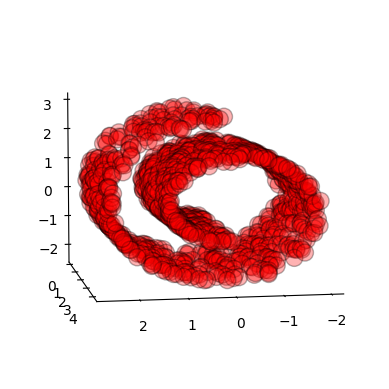

In [6]:
# Create a figure
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    samples_source[:, 0],
    samples_source[:, 1],
    samples_source[:, 2],
    c="r",
    edgecolors="k", 
    s=150, 
    alpha=0.3,
    #cmap="bwr",
)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(7, 80)

# Show the plot
plt.show()

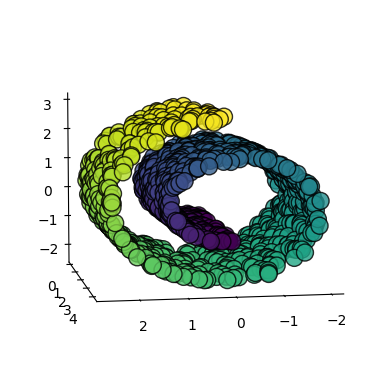

In [7]:
# Create a figure
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    samples_source[:, 0],
    samples_source[:, 1],
    samples_source[:, 2],
    c=samples_source_c,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap='viridis',
)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(7, 80)

# Show the plot
plt.show()

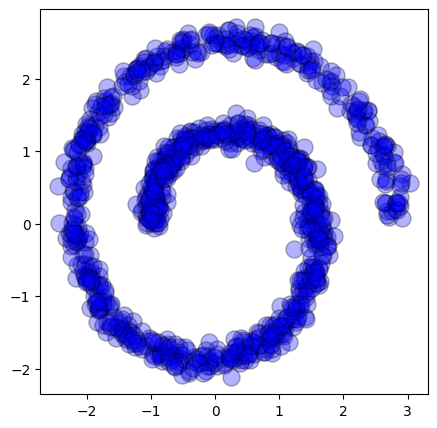

In [8]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1, 1,1)
ax.scatter(
    samples_target[:, 0],
    samples_target[:, 1],
    c="b",
    edgecolors="k", 
    s=150, 
    alpha=0.3,
)

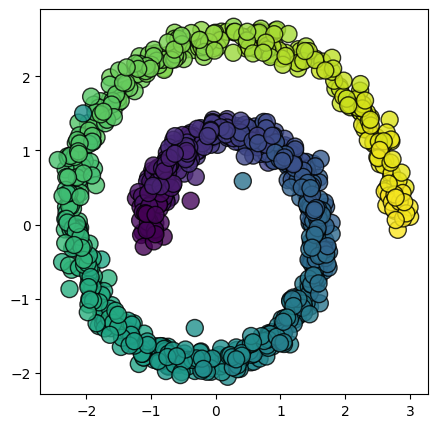

In [9]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1, 1,1)
ax.scatter(
    transported_source[0, :, 0],
    transported_source[0, :, 1],
    c=samples_source_c,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap='viridis',
)

### Conditional distribution 

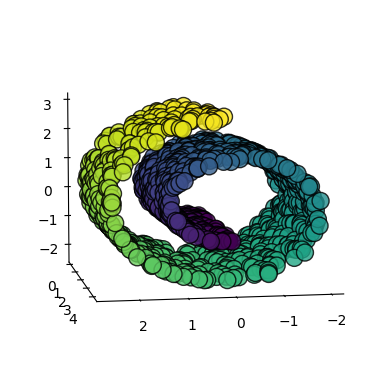

In [10]:
# Create a figure
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    samples_source[:, 0],
    samples_source[:, 1],
    samples_source[:, 2],
    c=samples_source_c,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="viridis",
)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(7, 80)

# Show the plot
plt.show()

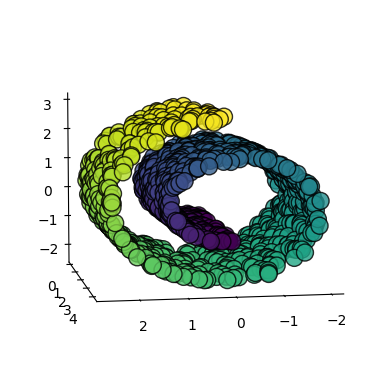

In [11]:
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    samples_source[:, 0],
    samples_source[:, 1],
    samples_source[:, 2],
    c=samples_source_c,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="viridis",
)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(7, 80)

# Show the plot
plt.show()

In [12]:
inds = [0, 200, 500, 800, 900]

source_selected = samples_source[inds,:]
source_selected_c = samples_source_c[inds]

In [13]:
const_source = np.repeat(source_selected, 10, axis=0)
const_source_c = np.repeat(source_selected_c, 10, axis=0)

In [14]:
source_selected_transport = otfm.transport(const_source)

/tmp/ipykernel_2908756/2223468942.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(


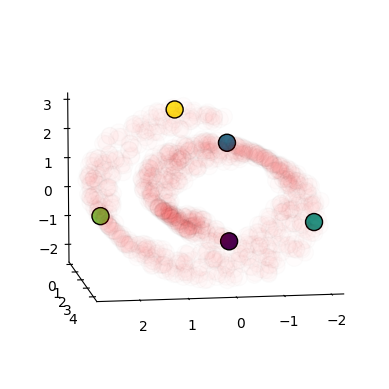

In [15]:
# Create a figure
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    samples_source[:, 0],
    samples_source[:, 1],
    samples_source[:, 2],
    c="r",
    edgecolors="k", 
    s=150, 
    alpha=0.01,
    cmap="bwr",
)

ax1.scatter(
    source_selected[:, 0],
    source_selected[:, 1],
    source_selected[:, 2],
    c=source_selected_c,
    edgecolors="k", 
    s=150, 
    alpha=1.0,
    cmap="viridis",
)



ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(7, 80)

# Show the plot
plt.show()

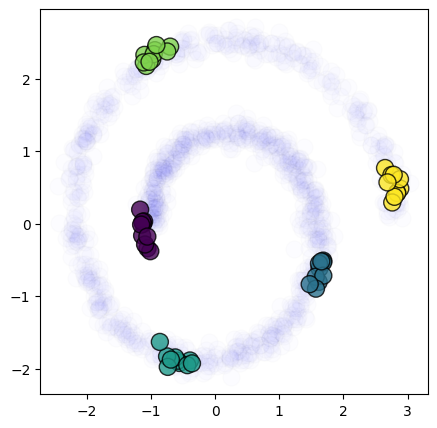

In [16]:
fig = plt.figure(figsize=(5,5))


ax = fig.add_subplot(1, 1,1)
ax.scatter(
    samples_target[:, 0],
    samples_target[:, 1],
    c="b",
    edgecolors="k", 
    s=150, 
    alpha=0.01,
    #cmap="summer",
)

ax.scatter(
    source_selected_transport[0][0,:, 0],
    source_selected_transport[0][0,:, 1],
    c=const_source_c,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="viridis",
)

In [203]:
samples_source[]

(1024, 3)

/tmp/ipykernel_137260/3748781643.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(


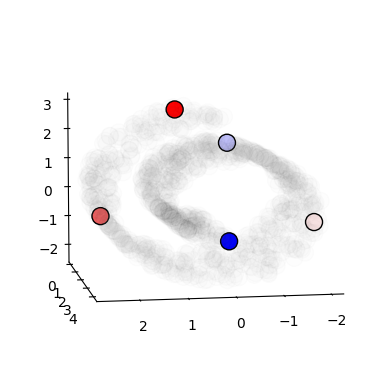

In [207]:
# Create a figure
inds = [0, 200, 500, 800, 900]

source_selected = samples_source[inds,:]
source_selected_c = samples_source_c[inds]


fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    samples_source[:, 0],
    samples_source[:, 1],
    samples_source[:, 2],
    c="gray",
    edgecolors="k", 
    s=150, 
    alpha=0.01,
    cmap="bwr",
)

ax1.scatter(
    source_selected[:, 0],
    source_selected[:, 1],
    source_selected[:, 2],
    c=source_selected_c,
    edgecolors="k", 
    s=150, 
    alpha=1.0,
    cmap="bwr",
)



ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(7, 80)

# Show the plot
plt.show()

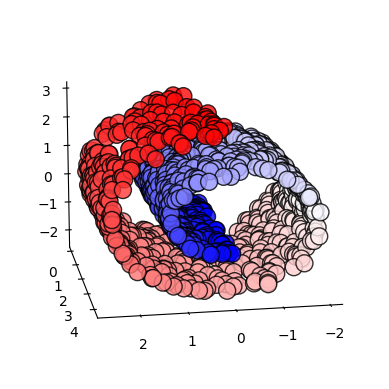

In [145]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=colors_source,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="bwr",
)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(15, 80)

# Show the plot
plt.show()


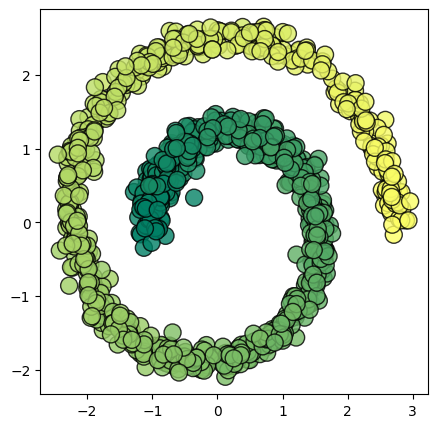

In [128]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(5,5))
points=source_together
col_points=colors_together
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 1,1)
ax.scatter(
    points[:, 0],
    points[:, 1],
    c=col_points,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="summer",
)

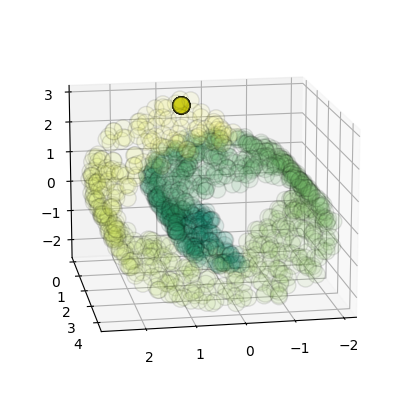

In [127]:
fig = plt.figure(figsize=(5,5))
points=samples_source

ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=colors_source,
    edgecolors="k", 
    s=150, 
    alpha=0.1,
    cmap="summer"
)

ax1.scatter(
    const_source[:, 0],
    const_source[:, 1],
    const_source[:, 2],
    c="r",
    edgecolors="k", 
    s=150, 
    alpha=0.8,
)


ax1.view_init(15,80)


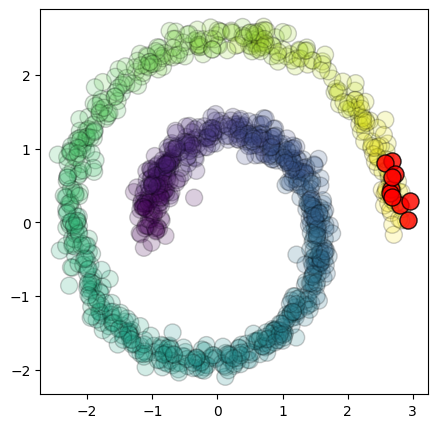

In [117]:
fig = plt.figure(figsize=(5,5))
points=source_together
col_points=colors_together

ax = fig.add_subplot(1, 1,1)
ax.scatter(
    points[:, 0],
    points[:, 1],
    c=col_points,
    edgecolors="k", 
    s=150, 
    alpha=0.1,
)

ax.scatter(
    res2[0][:, 0],
    res2[0][:, 1],
    c="r",
    edgecolors="k", 
    s=150, 
    alpha=0.8,
)

In [ ]:
const_source = np.repeat(samples_source[0][None,:], 10, axis=0)
res2, _, _ = otfm.transport(const_source)